In [435]:
import copy
import mujoco
from dm_control import mjcf
import numpy as np
import cv2
import scipy
from scipy.spatial.transform import Rotation as Rotater
import common
from dm_control.mujoco import Physics
from lxml import etree
from dm_control.suite import base
from dm_control.rl import control
from dm_control import viewer
import mediapy as media
import matplotlib.pyplot as plt
import json
import time

np.set_printoptions(precision=5, suppress=True)

In [436]:

def compute_gains(model, data, configuration, Q, R):
    # 1. Set configuration and find control that stabilizes it (ctrl0)
    newdata = mujoco.MjData(model)
    newdata = copy.copy(data)

    mujoco.mj_resetData(model, newdata)
    newdata.qpos = configuration
    # compute the control
    mujoco.mj_forward(model, newdata)
    newdata.qacc = 0
    mujoco.mj_inverse(model, newdata)

    # define control and configuration to linearize around
    # print(newdata.qfrc_actuator)
    ctrl0 = newdata.qfrc_inverse.copy() @ np.linalg.pinv(newdata.actuator_moment)
    # ctrl0[:] = 0
    qpos0 = newdata.qpos.copy()
    print('ctrl0:\n', ctrl0)
    print('qpos0:\n', qpos0)

    # 2. Compute LQR gains given weights
    mujoco.mj_resetData(model, newdata)
    newdata.ctrl = ctrl0
    newdata.qpos = qpos0
    # print('newdata.ctrl:\n', newdata.ctrl)

    # 3. Allocate the A and B matrices, compute them.
    A = np.zeros((2 * model.nv, 2 * model.nv))
    B = np.zeros((2 * model.nv, model.nu))
    epsilon = 1e-6
    flg_centered = True
    mujoco.mjd_transitionFD(model, newdata, epsilon, flg_centered, A, B, None, None)
    
    #save A and B into json file which name is formatted with suffix of time
    # cur_time = time.strftime('%Y%m%d_%H%M%S')
    # with open('A_B_{}.json'.format(cur_time), 'w') as f:
    #     json.dump({'A': A.tolist(), 'B': B.tolist()}, f, indent=2)

    #print A, B, Q, R in format 'A:\n{}\n'
    print('A:\n{}\nB:\n{}\nQ:\n{}\nR:\n{}'.format(A.shape, B.shape, Q.shape, R.shape))
    print('A:\n{}\nB:\n{}\nQ:\n{}\nR:\n{}'.format(A, B, Q, R))

    # return None, None

    # Solve discrete Riccati equation.
    P = scipy.linalg.solve_discrete_are(A, B, Q, R)
    print('P:\n{}'.format(P.shape))

    # Compute the feedback gain matrix K.
    K = np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A

    #print P, K in format 'A:\n{}\n'
    print('P:\n{}\nK:\n{}'.format(P, K))

    return ctrl0, K

In [437]:
def plot_curve(qhist, target, dqlist, ctrlist, delta_ctrlist):
    qdatas = np.array(qhist)
    #draw q in a plot
    plt.plot(qdatas[:, 0], marker="+", linestyle="-", label='qpos 0')
    # plt.plot(qdatas[:, 2], marker="+", linestyle="-", label='qpos 2')
    # plt.plot(qdatas[:, 3], marker="+", linestyle="-", label='qpos 3')
    #draw dq in a plot
    dqdatas = np.array(dqlist)
    plt.plot(dqdatas[:, 0], label='diffpos 0')
    # plt.plot(dqdatas[:, 2], label='diffpos 2')
    # plt.plot(dqdatas[:, 3], label='diffpos 3')
    #draw ctrl in a plot
    ctrdatas = np.array(ctrlist)
    plt.plot(ctrdatas[:, 2], linestyle=":", label='ctrl 2')
    plt.plot(ctrdatas[:, 3], linestyle=":", label='ctrl 3')
    #draw delta_ctrl in a plot
    delta_ctrdatas = np.array(delta_ctrlist)
    plt.plot(delta_ctrdatas[:, 2], linestyle="--", label='delta_ctrl 2')
    plt.plot(delta_ctrdatas[:, 3], linestyle="--", label='delta_ctrl 3')
    #show x=0 line
    plt.axhline(y=0, color='r', linestyle='--')
    plt.axhline(y=target[0], color='r', linestyle='--')
    plt.legend()
    #set y axis range
    plt.ylim(-target[0]*1.5, target[0]*1.5)

    plt.draw()
    plot_img = plt.gcf().canvas.buffer_rgba()
    plot_img = np.array(plot_img)[:,:,:3]

    return plot_img

sim_model.nv: 14 sim_model.nu: 4 sim_model.nq: 15 sim_model.na: 0
sim_data.qpos: [0.    0.    0.109 1.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.   ] 
sim_data.qvel: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
sim_data.qacc: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
sim_data.ctrl: [0. 0. 0. 0.]
sim_data.site_xpos: [[0. 0. 0.]] 
sim_data.site_xmat: [[0. 0. 0. 0. 0. 0. 0. 0. 0.]]
ang_euler: [0, 10, 0] quat: [0.      0.08716 0.      0.99619]
ctrl0:
 [ 0.04503  0.04503 -0.      -0.     ]
qpos0:
 [0.      0.      0.10734 0.99619 0.      0.08716 0.      0.      0.
 0.      0.      0.      0.      0.      0.     ]
A:
(28, 28)
B:
(28, 4)
Q:
(28, 28)
R:
(4, 4)
A:
[[  1.        0.       -0.00076  -0.       -0.00001   0.       -0.00004
    0.00002   0.00001   0.       -0.00004   0.00002   0.00001   0.
    0.002     0.       -0.00003  -0.       -0.       -0.       -0.
    0.       -0.        0.       -0.        0.       -0.        0.     ]
 [  0.        1.       -0.       

Exception ignored in: <function Renderer.__del__ at 0x1088de160>
Traceback (most recent call last):
  File "/Users/starimpact/Work/myvenvs/robot/lib/python3.12/site-packages/mujoco/renderer.py", line 335, in __del__
    self.close()
  File "/Users/starimpact/Work/myvenvs/robot/lib/python3.12/site-packages/mujoco/renderer.py", line 320, in close
    if self._gl_context:
       ^^^^^^^^^^^^^^^^
AttributeError: 'Renderer' object has no attribute '_gl_context'
Exception ignored in: <function Renderer.__del__ at 0x1088de160>
Traceback (most recent call last):
  File "/Users/starimpact/Work/myvenvs/robot/lib/python3.12/site-packages/mujoco/renderer.py", line 335, in __del__
    self.close()
  File "/Users/starimpact/Work/myvenvs/robot/lib/python3.12/site-packages/mujoco/renderer.py", line 320, in close
    if self._gl_context:
       ^^^^^^^^^^^^^^^^
AttributeError: 'Renderer' object has no attribute '_gl_context'


sim_data.time: 0.2680000000000002
dq:
 [-0.93974 -0.      -0.0265   0.       0.17278 -0.       0.19471 -0.33024
  0.34911  2.08461  0.19471 -0.33024  0.34911  2.08461] 
sim_data.qpos:
 [ 0.06131 -0.       0.08388  0.99632  0.       0.08574 -0.       0.19212
 -0.32556  0.34425  2.12319  0.19212 -0.32556  0.34425  2.12319] 
sim_data.qvel:
 [ 0.52423 -0.       0.19108 -0.      -0.54319 -0.      -1.29565  2.33833
 -2.43073 19.29069 -1.29565  2.33833 -2.43073 19.29069]
sim_data.time: 0.2700000000000002
dq:
 [-0.93869 -0.      -0.02612  0.       0.1717  -0.       0.19212 -0.32556
  0.34425  2.12319  0.19212 -0.32556  0.34425  2.12319] 
sim_data.qpos:
 [ 0.06237 -0.       0.08426  0.99636  0.       0.0852  -0.       0.18952
 -0.32089  0.33939  2.16213  0.18952 -0.32089  0.33939  2.16213] 
sim_data.qvel:
 [ 0.52738 -0.       0.19081 -0.      -0.54986 -0.      -1.29991  2.33506
 -2.42934 19.47013 -1.29991  2.33506 -2.42934 19.47013]
sim_data.time: 0.2720000000000002
dq:
 [-0.93763 -0.      -0.0

KeyboardInterrupt: 

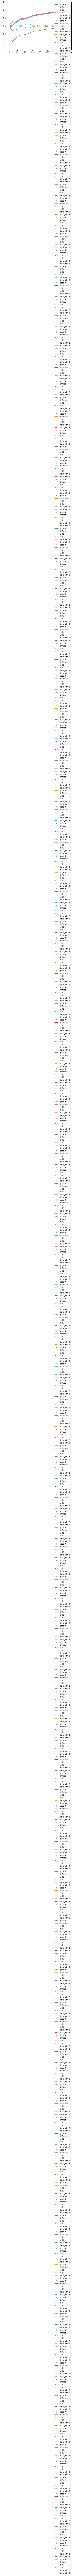

In [438]:
def simulate():

    CART_POLE_MJCF = "legwheel_robot2.xml" #"cartpole2.xml"
    sim_model = mujoco.MjModel.from_xml_path(CART_POLE_MJCF)
    sim_data = mujoco.MjData(sim_model)
    renderer = mujoco.Renderer(sim_model, height=int(480*1.5), width=int(640*1.5))

    # Make a new camera, move it to a closer distance.
    camera = mujoco.MjvCamera()
    mujoco.mjv_defaultFreeCamera(sim_model, camera)
    camera.lookat = [0, -0.3, 0.21]
    camera.azimuth = 90
    camera.elevation = -30
    camera.distance = 2
    q0 = copy.copy(sim_data.qpos)

    print('sim_model.nv:', sim_model.nv, 'sim_model.nu:', sim_model.nu, 'sim_model.nq:', sim_model.nq, 'sim_model.na:', sim_model.na)  
    print('sim_data.qpos:', sim_data.qpos, '\nsim_data.qvel:', sim_data.qvel, '\nsim_data.qacc:', sim_data.qacc, '\nsim_data.ctrl:', sim_data.ctrl)
    print('sim_data.site_xpos:', sim_data.site_xpos, '\nsim_data.site_xmat:', sim_data.site_xmat)

    # Parameters.
    DURATION = 10  # seconds
    BALANCE_STD = 0.2  # actuator units
    FRAMERATE = 30

    
    ang_euler = Rotater.from_quat([0, 0, 0, 1]).as_euler('xyz', degrees=True)
    ang_euler = [0, 10, 0]
    quat = Rotater.from_euler('xyz', ang_euler, degrees=True).as_quat()
    print('ang_euler:', ang_euler, 'quat:', quat)

    init_h = 0.109
    tgt_h = 0.11
    qpos0 = np.array([0., 0., init_h*np.cos(ang_euler[1]*np.pi/180), quat[3], quat[0], quat[1], quat[2], 0, 0, 0, 0, 0, 0, 0., 0.]) #give initial pose
    target = np.array([0., 0., init_h, 1., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0., 0.]) #give target pose which is the stable pose
    #x, y, z
    target[0] = 1.0#x
    target[1] = 0.0 #y
    target[2] = tgt_h #z
    #left and right wheel
    # target[10] = 1.0 #left wheel
    # target[14] = 1.0 #right wheel

    Q = np.eye(sim_model.nv*2) * 1e-6
    root_q_idx = [0, 1, 2, 3, 4, 5]
    root_v_idx = [14, 15, 16, 17, 18, 19]
    thigh_q_idx = [6, 10]
    thigh_v_idx = [20, 24]
    wheel_q_idx = [9, 13]
    wheel_v_idx = [23, 27]
    diagidx = root_q_idx + root_v_idx
    Q[diagidx, diagidx] = 1
    R = np.eye(sim_model.nu) * 1

    dq = np.zeros(sim_model.nv)
    # mujoco.mj_differentiatePos(sim_model, dq, 1, target, sim_data.qpos)
    # print('dq:', dq)
    # return

    # ctrl0, K = compute_gains(uncertain_model, uncertain_data, target)
    ctrl0, K = compute_gains(sim_model, sim_data, qpos0, Q, R)

    # return

    #print('ctrl0:', ctrl0, 'K:', K)

    # Reset data, set initial pose.
    mujoco.mj_resetData(sim_model, sim_data)
    sim_data.qpos = qpos0

    # Enable contact force visualisation.
    scene_option = mujoco.MjvOption()
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
    scene_option.frame = mujoco.mjtFrame.mjFRAME_WORLD

    qhist = []
    frames = []
    dqlist = []
    ctrlist = []
    delta_ctrlist = []
    while sim_data.time < DURATION:
        print("====================================")
        # Get state difference dx.
        mujoco.mj_differentiatePos(sim_model, dq, 1, target, sim_data.qpos)
        dx = np.hstack((dq, sim_data.qvel)).T

        # LQR control law.
        ctrl_noise = np.random.randn(sim_model.nu)/5
        
        if False:
            #only consider the subset of dx
            #failed
            dx_subset = np.zeros_like(dx)
            dx_subset[diagidx] = dx[diagidx]
            delta_ctrl = K @ dx_subset
        else:
            delta_ctrl = K @ dx
        sim_data.ctrl = ctrl0 - delta_ctrl# + ctrl_noise
        # print('ctrl:', sim_data.ctrl)
        print('sim_data.time:', sim_data.time)
        

        # Step the simulation.
        mujoco.mj_step(sim_model, sim_data)

        print('dq:\n', dq, "\nsim_data.qpos:\n", sim_data.qpos, "\nsim_data.qvel:\n", sim_data.qvel)

        # Save history.
        if len(frames) < sim_data.time * FRAMERATE:
            qhist.append(sim_data.qpos.copy())
            dqlist.append(dq.copy())
            ctrlist.append(sim_data.ctrl.copy())
            delta_ctrlist.append(delta_ctrl.copy())
            #camera.lookat = sim_data.body('root').subtree_com
            renderer.update_scene(sim_data, camera, scene_option)
            img = renderer.render()
            #draw frame number on image
            cv2.putText(img, str(len(frames)), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            frames.append(img)

    #draw plot image on the right side of frame
    plot_img = plot_curve(qhist, target, dqlist, ctrlist, delta_ctrlist)
    #resize plot image to the one-third size of frame keeping ratio
    tgt_h = frames[0].shape[0]//3
    tgt_w = int(plot_img.shape[1] * tgt_h / plot_img.shape[0])
    rsz_plot = cv2.resize(plot_img, (tgt_w, tgt_h))
    for img in frames:
        img[:rsz_plot.shape[0], -rsz_plot.shape[1]:] = rsz_plot
    print("show video:")
    media.show_video(frames, fps=10)#FRAMERATE)
    
    
simulate()